<a href="https://colab.research.google.com/github/Geopalut/AdversarialML/blob/master/basic_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Attacking a basic convnet 

In this notebook I will experiment with different adversaries using a basic convolutionnal neural network trained on CIFAR10 as the target. The notebook is organised as follows:

1. Building and training a basic net  
2. Building adversarial examples using FGSM
3. Building adversarial examples using a multiple step PGD
4. Trying to improve the defense of the network using adversarial training. 


### 1. The target network

For this example I build a basic convolutional neural network with three convolutionnal layers and two dense layers. 

There is also some light data processing to import CIFAR 10 images.

In [1]:
# Initial imports
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


#### Importing the data:
I use the torchvision data loader to download the CIFAR 10 dataset. Images are of size 32x32 pixels with 3 channels (RGB) each channel have values in [0,1]. I transform it to [-1,1].

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Setting up 

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Checking that a GPU is allocated to this session 
# if "cpu" appears, choose "GPU" in runtime > change runtime type > accelerator

print(device)

cuda:0


Visualizing a sample of images.
Images are blurry yet recognizable.

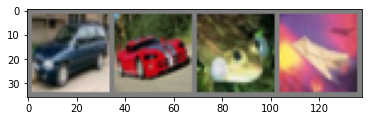

  car   car  frog plane


In [14]:
# functions to show an image (source : pytorch cifar_10 tutorial)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Defining the convolutional network. 

Next we create the conv net that will be targeted. 


In [24]:
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, 
                               padding=1) # adding 1 pixel of O padding on both sides 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, 
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                               padding=1)
        self.fc1 = nn.Linear(in_features= 32 * 4 * 4, out_features=128, bias=True)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening the output so it can be used in a dense layer
        x = x.view(x.size(0), -1) # resize to (size of the batch, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # no need to compute the softmax, it is part of the loss
        # criterion (cross_entropy)
        return x


net = ConvNet()
net = net.to(device) # using the gpu

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Defining the optimizer and the loss function.
I used cross entropy for the loss and Adam for the optimizer.

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001) # default parameters


Training loop 

In [27]:
for epoch in range(10):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # sending them to the GPU at each step
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.664
[1,  4000] loss: 1.389
[1,  6000] loss: 1.267
[2,  2000] loss: 1.162
[2,  4000] loss: 1.107
[2,  6000] loss: 1.082
[3,  2000] loss: 0.986
[3,  4000] loss: 0.989
[3,  6000] loss: 0.988
[4,  2000] loss: 0.908
[4,  4000] loss: 0.913
[4,  6000] loss: 0.923
[5,  2000] loss: 0.842
[5,  4000] loss: 0.865
[5,  6000] loss: 0.872
[6,  2000] loss: 0.801
[6,  4000] loss: 0.812
[6,  6000] loss: 0.830
[7,  2000] loss: 0.750
[7,  4000] loss: 0.780
[7,  6000] loss: 0.794
[8,  2000] loss: 0.725
[8,  4000] loss: 0.726
[8,  6000] loss: 0.772
[9,  2000] loss: 0.687
[9,  4000] loss: 0.715
[9,  6000] loss: 0.739
[10,  2000] loss: 0.659
[10,  4000] loss: 0.701
[10,  6000] loss: 0.705
Finished Training


In [ ]:
# saving the model 

# PATH = './cifar_net.pth'
# torch.save(net.state_dict(), PATH)

# loading the model

# net = Net()
# net.load_state_dict(torch.load(PATH))

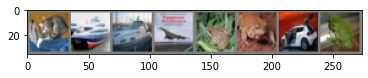

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:   ship  ship  ship plane  frog  frog   car  deer


In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

outputs = net(images.cuda())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

In [32]:
# network performances:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 66 %


In [36]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 82 %
Accuracy of  bird : 55 %
Accuracy of   cat : 62 %
Accuracy of  deer : 63 %
Accuracy of   dog : 39 %
Accuracy of  frog : 75 %
Accuracy of horse : 73 %
Accuracy of  ship : 74 %
Accuracy of truck : 79 %


We now have a simple model to attack. The performances are far from perfect but its enough to experiment with basic attacks.

### 2. FGSM adversary

This is a whitebox atttack where I have the full model and am able to compute the loss and its gradient to find the optimal direction in which to perturb the input.